#### O presente trabalho tem como intuito analisar a distribuição de leitos nas Unidades de Saúde Básicas em todo território nacional. Em todo o trabalho foram aplicados os conhecimentos adquiridos nas matérias Estatística Aplicada e Programação em R e Python, ministradas respectivamente pelo Prof. Paulo Canas e o Prof. Ricardo Rocha. 

#### Foi escolhida uma base real para a realização do trabalho, a idéia foi montar uma base que analisaria a quantidade de leitos em Unidades Básicas de Saúde em todo o Brasil ("BASE_DE_DADOS_CNES_201810", encontradada no endereço: http://cnes.datasus.gov.br/pages/downloads/arquivosBaseDados.jsp). A supracitada base é composta por 102 tabelas relacionais, contudo, foi feita a opção  de trabalhar com 3 dessas tabelas, são elas: "tbEstabelecimento201810.csv", "tbTipoUnidade201810.csv" e "rlEstabComplementar201810.csv" (cujo dicionário de dados segue em anexo). 

#### Como forma de enriquecer a base estudada, adicionamos variáveis encontradas no arquivo "DTB_BRASIL_MUNICIPIO.csv", disponível no endereço: ftp://geoftp.ibge.gov.br/organizacao_do_territorio/redes_e_fluxos_geograficos/gestao_do_territorio/bases_de_dados/xls/Base_de_dados_dos_municipios.xls, o que possibilitou uma análise descritiva mais apurada acrescentando à base principal variáveis como: UF e Município. 
   
#### Posteriormente, como forma de estabelecer uma relação entre quantidade de leitos de um município e a população projetada do mesmo, foi acrescentada a base "estimativa_dou_2018_20181019.xls" , que trás em seu conteúdo a projeção populacional dos municípios do Brasil em 2018, encontrada no endereço: https://www.ibge.gov.br/estatisticas-novoportal/sociais/populacao/9103-estimativas-de-populacao.html?=&t=downloads.

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import desc 
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from pivottablejs import pivot_ui
import pandas as pd
import qgrid 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.tools as tls
import numpy as np
%matplotlib inline

# MONTAGEM DA BASE

In [2]:
base = spark.read.csv("tbEstabelecimento201810.csv",sep=";",header=True,inferSchema=True)
for x in base.columns:
    base = base.withColumnRenamed(x,"tbEstabelecimento_"+x)

In [3]:
base.printSchema()

root
 |-- tbEstabelecimento_CO_UNIDADE: string (nullable = true)
 |-- tbEstabelecimento_CO_CNES: integer (nullable = true)
 |-- tbEstabelecimento_NU_CNPJ_MANTENEDORA: long (nullable = true)
 |-- tbEstabelecimento_TP_PFPJ: integer (nullable = true)
 |-- tbEstabelecimento_NIVEL_DEP: integer (nullable = true)
 |-- tbEstabelecimento_NO_RAZAO_SOCIAL: string (nullable = true)
 |-- tbEstabelecimento_NO_FANTASIA: string (nullable = true)
 |-- tbEstabelecimento_NO_LOGRADOURO: string (nullable = true)
 |-- tbEstabelecimento_NU_ENDERECO: string (nullable = true)
 |-- tbEstabelecimento_NO_COMPLEMENTO: string (nullable = true)
 |-- tbEstabelecimento_NO_BAIRRO: string (nullable = true)
 |-- tbEstabelecimento_CO_CEP: integer (nullable = true)
 |-- tbEstabelecimento_CO_REGIAO_SAUDE: string (nullable = true)
 |-- tbEstabelecimento_CO_MICRO_REGIAO: string (nullable = true)
 |-- tbEstabelecimento_CO_DISTRITO_SANITARIO: string (nullable = true)
 |-- tbEstabelecimento_CO_DISTRITO_ADMINISTRATIVO: string (nu

In [3]:
base_tp_unidade = spark.read.csv("tbTipoUnidade201810.csv",sep=";",header=True,inferSchema=True)
for x in base_tp_unidade.columns:
    base_tp_unidade = base_tp_unidade.withColumnRenamed(x,"tbTipoUnidade_"+x)

In [22]:
base_tp_unidade.printSchema()

root
 |-- tbTipoUnidade_CO_TIPO_UNIDADE: integer (nullable = true)
 |-- tbTipoUnidade_DS_TIPO_UNIDADE: string (nullable = true)



In [4]:
base_cod_mun = spark.read.csv("DTB_BRASIL_MUNICIPIO.csv",sep=";",header=True,inferSchema=True)
for x in base_cod_mun.columns:
    base_cod_mun = base_cod_mun.withColumnRenamed(x,"dtbBrasilMunicipio_"+x)

In [23]:
base_cod_mun.printSchema()

root
 |-- dtbBrasilMunicipio_UF: integer (nullable = true)
 |-- dtbBrasilMunicipio_NOME_UF: string (nullable = true)
 |-- dtbBrasilMunicipio_MESO_GEO: integer (nullable = true)
 |-- dtbBrasilMunicipio_NOME_MESO: string (nullable = true)
 |-- dtbBrasilMunicipio_MICRO_GEO: integer (nullable = true)
 |-- dtbBrasilMunicipio_NOME_MICRO: string (nullable = true)
 |-- dtbBrasilMunicipio_MUNICIPIO: integer (nullable = true)
 |-- dtbBrasilMunicipio_CODMUNC_COMPLETO7: integer (nullable = true)
 |-- dtbBrasilMunicipio_CODMUNC_COMPLETO6: integer (nullable = true)
 |-- dtbBrasilMunicipio_NOME_MUNC: string (nullable = true)



In [5]:
base_complementar = spark.read.csv("rlEstabComplementar201810.csv",sep=";",header=True,inferSchema=True)
for x in base_complementar.columns:
    base_complementar = base_complementar.withColumnRenamed(x,"rlEstabComplementar_"+x)

In [24]:
base_complementar.printSchema()

root
 |-- rlEstabComplementar_CO_UNIDADE: string (nullable = true)
 |-- rlEstabComplementar_CO_LEITO: integer (nullable = true)
 |-- rlEstabComplementar_CO_TIPO_LEITO: double (nullable = true)
 |-- rlEstabComplementar_TP_ALTACOMP: string (nullable = true)
 |-- rlEstabComplementar_QT_EXIST: integer (nullable = true)
 |-- rlEstabComplementar_QT_CONTR: integer (nullable = true)
 |-- rlEstabComplementar_QT_SUS: integer (nullable = true)
 |-- rlEstabComplementar_TO_CHAR(DT_ATUALIZACAO,'DD/MM/YYYY'): string (nullable = true)
 |-- rlEstabComplementar_CO_USUARIO: string (nullable = true)
 |-- rlEstabComplementar_TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY'): string (nullable = true)



In [6]:
base_populacao = spark.read.csv("PROJ_POPULACIONAL_2018.csv",sep=";",header=True,inferSchema=True)
for x in base_populacao.columns:
    base_populacao = base_populacao.withColumnRenamed(x,"ibgePopulacao_"+x)

In [25]:
base_populacao.printSchema()

root
 |-- ibgePopulacao_UF: string (nullable = true)
 |-- ibgePopulacao_COD_REGIAO: integer (nullable = true)
 |-- ibgePopulacao_COD_UF: integer (nullable = true)
 |-- ibgePopulacao_COD_MUN_7: integer (nullable = true)
 |-- ibgePopulacao_COD_MUN_6: integer (nullable = true)
 |-- ibgePopulacao_NM_MUNICIPIO: string (nullable = true)
 |-- ibgePopulacao_POPULACAO_ESTIMADA: integer (nullable = true)



In [7]:
base_geo_final = base.select('tbEstabelecimento_CO_UNIDADE', 'tbEstabelecimento_CO_CNES', 'tbEstabelecimento_NO_LOGRADOURO', 'tbEstabelecimento_NU_ENDERECO', 'tbEstabelecimento_NO_COMPLEMENTO', 'tbEstabelecimento_NO_BAIRRO', 'tbEstabelecimento_CO_CEP', 'tbEstabelecimento_CO_ESTADO_GESTOR', 'tbEstabelecimento_CO_MUNICIPIO_GESTOR', 'tbEstabelecimento_TP_UNIDADE')

In [8]:
base_cod_mun = base_cod_mun.withColumnRenamed("dtbBrasilMunicipio_Mesorregião Geográfica", "dtbBrasilMunicipio_MESO_GEO").withColumnRenamed("dtbBrasilMunicipio_Nome_UF", "dtbBrasilMunicipio_NOME_UF").withColumnRenamed("dtbBrasilMunicipio_Nome_Mesorregião", "dtbBrasilMunicipio_NOME_MESO").withColumnRenamed("dtbBrasilMunicipio_Microrregião Geográfica", "dtbBrasilMunicipio_MICRO_GEO").withColumnRenamed("dtbBrasilMunicipio_Nome_Microrregião", "dtbBrasilMunicipio_NOME_MICRO").withColumnRenamed("dtbBrasilMunicipio_Município", "dtbBrasilMunicipio_MUNICIPIO").withColumnRenamed("dtbBrasilMunicipio_Código Município Completo7", "dtbBrasilMunicipio_CODMUNC_COMPLETO7").withColumnRenamed("dtbBrasilMunicipio_Nome_Município", "dtbBrasilMunicipio_NOME_MUNC").withColumnRenamed("dtbBrasilMunicipio_Código Município Completo6", "dtbBrasilMunicipio_CODMUNC_COMPLETO6")

In [9]:
base_geo_final = base_tp_unidade.join(base_geo_final,base_tp_unidade['tbTipoUnidade_CO_TIPO_UNIDADE'] ==base_geo_final['tbEstabelecimento_TP_UNIDADE'] ,'inner')

In [10]:
base_geo_final = base_complementar.join(base_geo_final,base_complementar['rlEstabComplementar_CO_UNIDADE'] ==base_geo_final['tbEstabelecimento_CO_UNIDADE'] ,'inner')

In [11]:
base_geo_final = base_cod_mun.join(base_geo_final,base_cod_mun['dtbBrasilMunicipio_CODMUNC_COMPLETO6'] ==base_geo_final['tbEstabelecimento_CO_MUNICIPIO_GESTOR'] ,'inner')

In [12]:
base_geo_final = base_geo_final.drop('tbEstabelecimento_CO_MUNICIPIO_GESTOR','rlEstabComplementar_CO_UNIDADE')

In [ ]:
#base_geo_final = base_geo_final.withColumn('tbEstabelecimento_ENDERECO',F.concat(F.col('tbEstabelecimento_NO_LOGRADOURO'),F.lit(' ,'), F.col('tbEstabelecimento_NU_ENDERECO'),F.lit(' ,'), F.col('tbEstabelecimento_NO_COMPLEMENTO'),F.lit(' ,'), F.col('tbEstabelecimento_NO_BAIRRO'),F.lit(' ,'), F.col('tbEstabelecimento_CO_CEP'),F.lit(' ,'), F.col('dtbBrasilMunicipio_NOME_UF')))

In [13]:
base_geo_final_select = base_geo_final.select('tbEstabelecimento_CO_UNIDADE','tbEstabelecimento_CO_CNES','tbEstabelecimento_TP_UNIDADE','tbTipoUnidade_DS_TIPO_UNIDADE','dtbBrasilMunicipio_UF','dtbBrasilMunicipio_CODMUNC_COMPLETO6','dtbBrasilMunicipio_NOME_MUNC','rlEstabComplementar_QT_EXIST','rlEstabComplementar_QT_SUS')

In [14]:
base_geo_final_select = base_geo_final_select.withColumn("dtbBrasilMunicipio_COD_REGIAO",F.substring("dtbBrasilMunicipio_CODMUNC_COMPLETO6",1,1))

In [15]:
base_geo_final_select = base_geo_final_select.withColumn("dtbBrasilMunicipio_COD_ESTADO",F.substring("dtbBrasilMunicipio_CODMUNC_COMPLETO6",1,2))

In [16]:
base_agrup = base_geo_final_select.groupby("tbEstabelecimento_CO_UNIDADE","tbEstabelecimento_CO_CNES","tbEstabelecimento_TP_UNIDADE","tbTipoUnidade_DS_TIPO_UNIDADE","dtbBrasilMunicipio_UF","dtbBrasilMunicipio_COD_REGIAO","dtbBrasilMunicipio_CODMUNC_COMPLETO6","dtbBrasilMunicipio_NOME_MUNC").agg(F.sum("rlEstabComplementar_QT_EXIST").alias("total_Leitos"))

In [17]:
base_agrup_final = base_populacao.join(base_agrup,base_populacao['ibgePopulacao_COD_MUN_6'] ==base_agrup['dtbBrasilMunicipio_CODMUNC_COMPLETO6'] ,'inner')

In [18]:
base_agrup_final = base_agrup_final.withColumn("DS_REGIAO", F.when( (base_agrup_final["dtbBrasilMunicipio_COD_REGIAO"]==1), 'Norte').when( (base_agrup_final["dtbBrasilMunicipio_COD_REGIAO"]==2), 'Nordeste').when( (base_agrup_final["dtbBrasilMunicipio_COD_REGIAO"]==3), 'Sudeste').when( (base_agrup_final["dtbBrasilMunicipio_COD_REGIAO"]==4), 'Sul').otherwise('Centro-Oeste'))

In [19]:
base_agrup_final = base_agrup_final.select("tbEstabelecimento_CO_UNIDADE","tbEstabelecimento_CO_CNES","tbEstabelecimento_TP_UNIDADE","tbTipoUnidade_DS_TIPO_UNIDADE","dtbBrasilMunicipio_UF","ibgePopulacao_UF","dtbBrasilMunicipio_COD_REGIAO","DS_REGIAO","dtbBrasilMunicipio_CODMUNC_COMPLETO6","dtbBrasilMunicipio_NOME_MUNC","ibgePopulacao_POPULACAO_ESTIMADA","total_Leitos")

In [26]:
base_agrup_final.printSchema()

root
 |-- tbEstabelecimento_CO_UNIDADE: string (nullable = true)
 |-- tbEstabelecimento_CO_CNES: integer (nullable = true)
 |-- tbEstabelecimento_TP_UNIDADE: integer (nullable = true)
 |-- tbTipoUnidade_DS_TIPO_UNIDADE: string (nullable = true)
 |-- dtbBrasilMunicipio_UF: integer (nullable = true)
 |-- ibgePopulacao_UF: string (nullable = true)
 |-- dtbBrasilMunicipio_COD_REGIAO: string (nullable = true)
 |-- DS_REGIAO: string (nullable = false)
 |-- dtbBrasilMunicipio_CODMUNC_COMPLETO6: integer (nullable = true)
 |-- dtbBrasilMunicipio_NOME_MUNC: string (nullable = true)
 |-- ibgePopulacao_POPULACAO_ESTIMADA: integer (nullable = true)
 |-- total_Leitos: long (nullable = true)



In [20]:
base_agrup_final.show(5,False)

+----------------------------+-------------------------+----------------------------+-----------------------------+---------------------+----------------+-----------------------------+------------+------------------------------------+----------------------------+--------------------------------+------------+
|tbEstabelecimento_CO_UNIDADE|tbEstabelecimento_CO_CNES|tbEstabelecimento_TP_UNIDADE|tbTipoUnidade_DS_TIPO_UNIDADE|dtbBrasilMunicipio_UF|ibgePopulacao_UF|dtbBrasilMunicipio_COD_REGIAO|DS_REGIAO   |dtbBrasilMunicipio_CODMUNC_COMPLETO6|dtbBrasilMunicipio_NOME_MUNC|ibgePopulacao_POPULACAO_ESTIMADA|total_Leitos|
+----------------------------+-------------------------+----------------------------+-----------------------------+---------------------+----------------+-----------------------------+------------+------------------------------------+----------------------------+--------------------------------+------------+
|3108602119412               |2119412                  |5             

## Conversão da base principal no formato CSV

In [ ]:
base_agrup_final.repartition(1).write.csv("base_agrup_FINAL1.csv", sep=';', header=True)

# DESCRITIVA

####  A base de dados em análise possui como População as Unidades Básicas de Saúde dos Municípios do Brasil, sendo classificada como finita uma vez que seus elementos são finitos. Por sua vez tem-se como Amostra retratada neste estudo, a quantidade de leitos das Unidades Básicas de cada Município do Brasil.

In [2]:
data = spark.read.csv("base_agrup_FINAL1.csv",sep=";",header=True,inferSchema=True)

#### Verificação se os campos da base estão devidamente preenchidos.

In [35]:
base = data
tamanho = base.count()
for coluna in base.columns:
        nao_nulos = base.filter(F.col(coluna).isNotNull()).count()
        nao_nulos = float(nao_nulos)
        res =  (nao_nulos/tamanho) *100
        print (coluna+","+str(nao_nulos)+","+str(res))

tbEstabelecimento_CO_UNIDADE,9281.0,100.0
tbEstabelecimento_CO_CNES,9281.0,100.0
tbEstabelecimento_TP_UNIDADE,9281.0,100.0
tbTipoUnidade_DS_TIPO_UNIDADE,9281.0,100.0
dtbBrasilMunicipio_UF,9281.0,100.0
ibgePopulacao_UF,9281.0,100.0
dtbBrasilMunicipio_COD_REGIAO,9281.0,100.0
DS_REGIAO,9281.0,100.0
dtbBrasilMunicipio_CODMUNC_COMPLETO6,9281.0,100.0
dtbBrasilMunicipio_NOME_MUNC,9281.0,100.0
ibgePopulacao_POPULACAO_ESTIMADA,9281.0,100.0
total_Leitos,9281.0,100.0


## Criação de bases-recorte para análises descritivas em Pyspark.

In [5]:
data1 = data.groupby("tbTipoUnidade_DS_TIPO_UNIDADE").agg(F.sum("total_Leitos").alias("total_Leitos"))
data2 = data.groupby("DS_REGIAO").agg(F.sum("total_Leitos").alias("total_Leitos"))
data3 = data.groupby("ibgePopulacao_UF").agg(F.sum("total_Leitos").alias("total_Leitos"))
data4 = data.groupby("dtbBrasilMunicipio_UF","ibgePopulacao_UF","dtbBrasilMunicipio_COD_REGIAO","DS_REGIAO","dtbBrasilMunicipio_NOME_MUNC","dtbBrasilMunicipio_CODMUNC_COMPLETO6","ibgePopulacao_POPULACAO_ESTIMADA").agg(F.sum("total_Leitos").alias("total_Leitos"))
data5 = data4.select("ibgePopulacao_POPULACAO_ESTIMADA","total_Leitos")
data6 = data.groupby("DS_REGIAO").agg(F.sum("ibgePopulacao_POPULACAO_ESTIMADA").alias("total_Populacao"))
data7 = data.groupby("ibgePopulacao_UF").agg(F.sum("ibgePopulacao_POPULACAO_ESTIMADA").alias("total_Populacao"))


## Conversão das bases-recorte supracitadas de Pyspark para Pandas.

In [6]:
data1pandas = data1.toPandas()
data2pandas = data2.toPandas()
data3pandas = data3.toPandas()
data4pandas = data4.toPandas()
data5pandas = data5.toPandas()
data6pandas = data6.toPandas()
data7pandas = data7.toPandas()

## Leitura da base principal diretamente no Pandas , "head" e "shape" da base.

In [3]:
datapandas = pd.read_csv('base_agrup_FINAL1.csv', sep=';')
datapandas.head()

,tbEstabelecimento_CO_UNIDADE,tbEstabelecimento_CO_CNES,tbEstabelecimento_TP_UNIDADE,tbTipoUnidade_DS_TIPO_UNIDADE,dtbBrasilMunicipio_UF,ibgePopulacao_UF,dtbBrasilMunicipio_COD_REGIAO,DS_REGIAO,dtbBrasilMunicipio_CODMUNC_COMPLETO6,dtbBrasilMunicipio_NOME_MUNC,ibgePopulacao_POPULACAO_ESTIMADA,total_Leitos
0,3108602119412,2119412,5,HOSPITAL GERAL,31,MG,3,Sudeste,310860,Brasília de Minas,32288,18
1,5201403225143,3225143,7,HOSPITAL ESPECIALIZADO,52,GO,5,Centro-Oeste,520140,Aparecida de Goiânia,565957,6
2,2927405616387,5616387,5,HOSPITAL GERAL,29,BA,2,Nordeste,292740,Salvador,2857329,32
3,3525209452354,9452354,5,HOSPITAL GERAL,35,SP,3,Sudeste,352520,Jarinu,29456,12
4,2108302454947,2454947,5,HOSPITAL GERAL,21,MA,2,Nordeste,210830,Penalva,38203,48


In [4]:
qgrid_widget = qgrid.show_grid(datapandas,show_toolbar=True) 
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
pivot_ui(datapandas)

### Os tipos de variáveis supracitados são:

#### tbTipoUnidade_DS_TIPO_UNIDADE = Variável qualitativa nominal
#### ibgePopulacao_UF = Variável qualitativa nominal
#### DS_REGIAO = Variável qualitativa nominal
#### dtbBrasilMunicipio_NOME_MUNC = Variável qualitativa nominal
#### ibgePopulacao_POPULACAO_ESTIMADA = Variável quantitativa discreta
#### total_Leitos = Variável quantitativa discreta

In [14]:
datapandas.shape

(9281, 12)

## Destribuição da população por Regiões.

In [45]:
data6.show(50,False)

+------------+---------------+
|DS_REGIAO   |total_Populacao|
+------------+---------------+
|Nordeste    |1321989519     |
|Sul         |350850079      |
|Sudeste     |7396755949     |
|Centro-Oeste|623426388      |
|Norte       |309750273      |
+------------+---------------+



Text(0.5,1,'Regiões do Brasil x População')

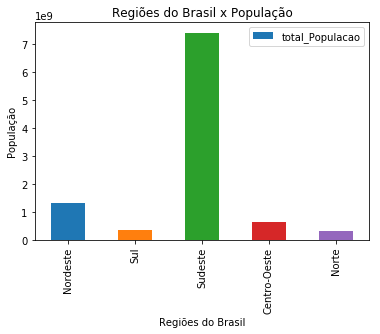

In [46]:
data6pandas.plot(kind='bar', x='DS_REGIAO', y='total_Populacao')
plt.xlabel('Regiões do Brasil')
plt.ylabel('População')
plt.title('Regiões do Brasil x População')

## Destribuição da população por Unidade Federativa.

In [48]:
data7.show(30,False)

+----------------+---------------+
|ibgePopulacao_UF|total_Populacao|
+----------------+---------------+
|SC              |46011443       |
|RO              |19462744       |
|PI              |54401624       |
|AM              |139618510      |
|RR              |3975098        |
|GO              |242131612      |
|TO              |8268035        |
|MT              |28686842       |
|SP              |4480976236     |
|PB              |66243221       |
|ES              |29988224       |
|RS              |83643115       |
|MS              |40264119       |
|AL              |59963738       |
|MG              |383302821      |
|PA              |127769444      |
|BA              |445280387      |
|SE              |30060705       |
|PE              |204066919      |
|CE              |326952131      |
|RN              |56249277       |
|RJ              |2502488668     |
|MA              |78771517       |
|AC              |5280876        |
|DF              |312343815      |
|PR              |22

Text(0.5,1,'Unidades Federativas x População')

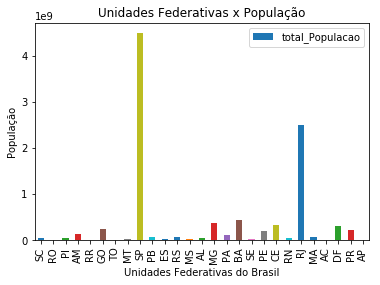

In [49]:
data7pandas.plot(kind='bar', x='ibgePopulacao_UF', y='total_Populacao')
plt.xlabel('Unidades Federativas do Brasil')
plt.ylabel('População')
plt.title('Unidades Federativas x População')

## Tipos de Unidades Básicas de Saúde e seus respectivos leitos totais no Brasil.

In [37]:
data1.show(100,False)

+------------------------------------------------------------+------------+
|tbTipoUnidade_DS_TIPO_UNIDADE                               |total_Leitos|
+------------------------------------------------------------+------------+
|HOSPITAL ESPECIALIZADO                                      |92238       |
|CENTRO DE PARTO NORMAL - ISOLADO                            |231         |
|SERVICO DE ATENCAO DOMICILIAR ISOLADO(HOME CARE)            |173         |
|UNIDADE DE ATENCAO EM REGIME RESIDENCIAL                    |224         |
|CENTRAL DE REGULACAO MEDICA DAS URGENCIAS                   |1           |
|LABORATORIO DE SAUDE PUBLICA                                |1           |
|HOSPITAL/DIA - ISOLADO                                      |6363        |
|UNIDADE MISTA                                               |11463       |
|CENTRO DE ATENCAO HEMOTERAPIA E OU HEMATOLOGICA             |55          |
|CLINICA/CENTRO DE ESPECIALIDADE                             |5122        |
|CENTRO DE A

Text(0.5,1,'Quantidade de Leitos / Tipo de Unidade Basica')

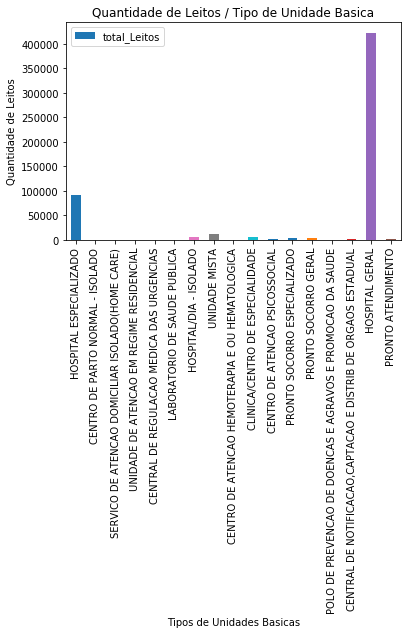

In [76]:
data1pandas.plot(kind='bar', x='tbTipoUnidade_DS_TIPO_UNIDADE', y='total_Leitos')
plt.xlabel('Tipos de Unidades Basicas')
plt.ylabel('Quantidade de Leitos')
plt.title('Quantidade de Leitos / Tipo de Unidade Basica')

## Quantidade de Leitos por Região do Brasil.

In [5]:
data2.show(30,False)

+------------+------------+
|DS_REGIAO   |total_Leitos|
+------------+------------+
|Nordeste    |140333      |
|Sul         |87158       |
|Sudeste     |236444      |
|Centro-Oeste|45471       |
|Norte       |38826       |
+------------+------------+



Text(0.5,1,'Quantidade de Leitos X Regioes do Brasil')

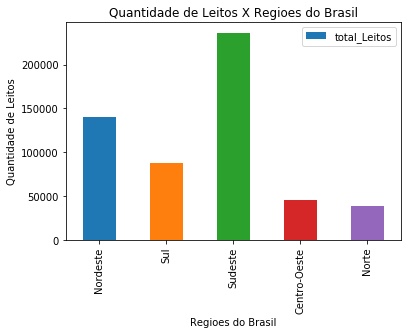

In [21]:
data2pandas.plot(kind='bar', x='DS_REGIAO', y='total_Leitos')
plt.xlabel('Regioes do Brasil')
plt.ylabel('Quantidade de Leitos')
plt.title('Quantidade de Leitos X Regioes do Brasil')

## Total de Leitos Por Unidade Federativa.

In [6]:

data3.show(30,False)

+----------------+------------+
|ibgePopulacao_UF|total_Leitos|
+----------------+------------+
|SC              |17943       |
|RO              |5137        |
|PI              |8696        |
|AM              |7408        |
|RR              |1165        |
|GO              |20911       |
|TO              |3249        |
|MT              |8887        |
|SP              |118495      |
|PB              |11320       |
|ES              |10274       |
|RS              |35397       |
|MS              |6707        |
|AL              |7079        |
|MG              |49270       |
|PA              |18815       |
|BA              |34479       |
|SE              |3865        |
|PE              |26402       |
|CE              |22098       |
|RN              |9144        |
|RJ              |58405       |
|MA              |17250       |
|AC              |1667        |
|DF              |8966        |
|PR              |33818       |
|AP              |1385        |
+----------------+------------+



Text(0.5,1,'Quantidade de Leitos X Unidades Federativas do Brasil')

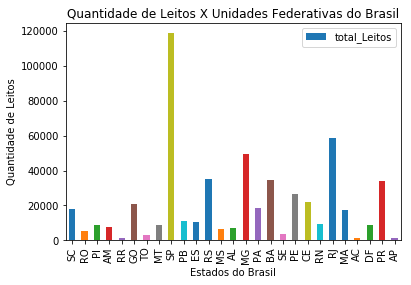

In [42]:
data3pandas.plot(kind='bar', x='ibgePopulacao_UF', y='total_Leitos')
plt.xlabel('Estados do Brasil')
plt.ylabel('Quantidade de Leitos')
plt.title('Quantidade de Leitos X Unidades Federativas do Brasil')

## Agrupamento da quantidade de leitos por Municípios do Brasil.

In [16]:
data4.show(30,False)

+---------------------+----------------+-----------------------------+------------+----------------------------+------------------------------------+--------------------------------+------------+
|dtbBrasilMunicipio_UF|ibgePopulacao_UF|dtbBrasilMunicipio_COD_REGIAO|DS_REGIAO   |dtbBrasilMunicipio_NOME_MUNC|dtbBrasilMunicipio_CODMUNC_COMPLETO6|ibgePopulacao_POPULACAO_ESTIMADA|total_Leitos|
+---------------------+----------------+-----------------------------+------------+----------------------------+------------------------------------+--------------------------------+------------+
|25                   |PB              |2                            |Nordeste    |João Pessoa                 |250750                              |800323                          |4045        |
|25                   |PB              |2                            |Nordeste    |Pedras de Fogo              |251120                              |28389                           |52          |
|41                 

## População estimada dos Municípios do Brasil x Quantidade de Leitos por Município.

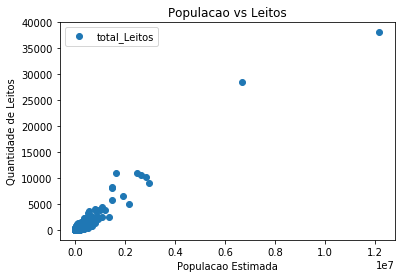

In [18]:
data5pandas.plot(x='ibgePopulacao_POPULACAO_ESTIMADA', y='total_Leitos', style='o')  
plt.title('Populacao vs Leitos')  
plt.xlabel('Populacao Estimada')  
plt.ylabel('Quantidade de Leitos')  
plt.show()

## Parâmetros da Base

#### Depois de agrupada a base, foram encontrados 3714 Municípios que possuem Unidades Básicas de Saúde, com média de leitos de 147,61 e desvio padrão de 944,28. O município com menor quantidade de leitos, possui 1 leito e o com maior quantidade possui 38075 leitos.

In [9]:
data4pandas.total_Leitos.describe()

count     3714.000000
mean       147.612278
std        944.281791
min          1.000000
25%         20.000000
50%         35.000000
75%         73.000000
max      38075.000000
Name: total_Leitos, dtype: float64

Text(0,0.5,'Quantidade de Leitos')

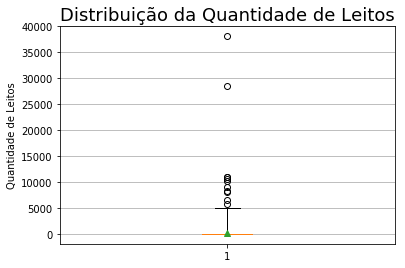

In [44]:
box = plt.boxplot(data4pandas.total_Leitos, showmeans=True, whis=99)
plt.setp(box['boxes'][0], color='green')
plt.setp(box['caps'][0], color='green')
plt.setp(box['whiskers'][0], color='green')
plt.grid(True, axis='y')
plt.title('Distribuição da Quantidade de Leitos', fontsize=18)
plt.ylabel('Quantidade de Leitos')

#### Aplicando o método de Pearson, constata-se que as variáveis que quardam maior correlação entre si são "ibgePopulacao_POPULACAO_ESTIMADA" e "total_Leitos" com 0.971228. A posteriori algumas das variáveis citadas serão utilizadas na regressão linear.

In [22]:
print(data4pandas.corr())

                                      dtbBrasilMunicipio_UF  \
dtbBrasilMunicipio_UF                              1.000000   
dtbBrasilMunicipio_COD_REGIAO                      0.976834   
dtbBrasilMunicipio_CODMUNC_COMPLETO6               0.999905   
ibgePopulacao_POPULACAO_ESTIMADA                   0.006499   
total_Leitos                                       0.016052   

                                      dtbBrasilMunicipio_COD_REGIAO  \
dtbBrasilMunicipio_UF                                      0.976834   
dtbBrasilMunicipio_COD_REGIAO                              1.000000   
dtbBrasilMunicipio_CODMUNC_COMPLETO6                       0.976674   
ibgePopulacao_POPULACAO_ESTIMADA                           0.001208   
total_Leitos                                               0.012316   

                                      dtbBrasilMunicipio_CODMUNC_COMPLETO6  \
dtbBrasilMunicipio_UF                                             0.999905   
dtbBrasilMunicipio_COD_REGIAO         

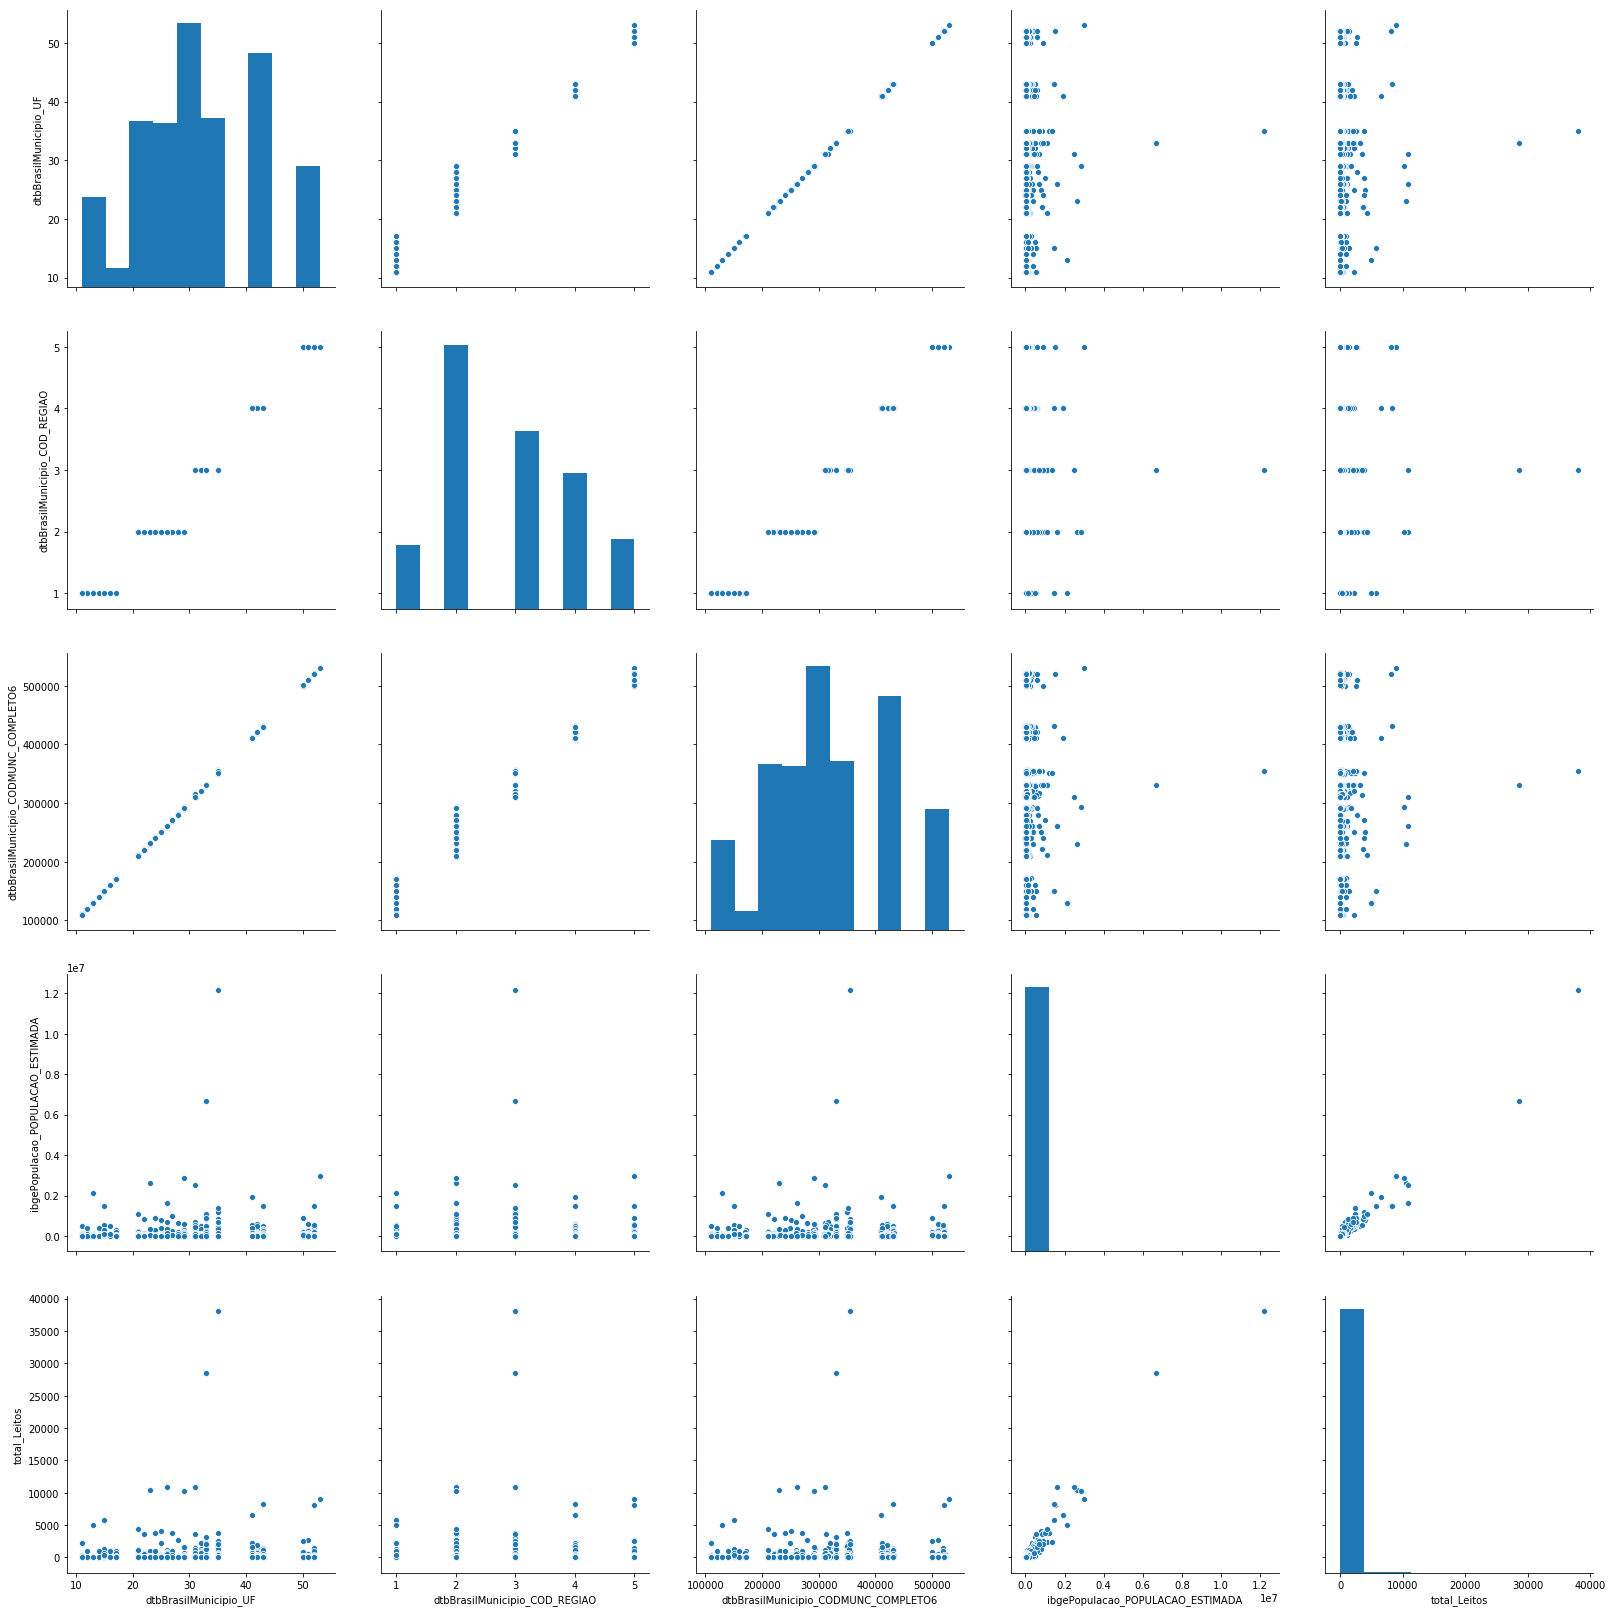

In [10]:
cols = ['dtbBrasilMunicipio_UF', 'dtbBrasilMunicipio_COD_REGIAO', 'dtbBrasilMunicipio_CODMUNC_COMPLETO6', 'ibgePopulacao_POPULACAO_ESTIMADA', 'total_Leitos']
sns.pairplot(data4pandas[cols], height=4.5)
plt.tight_layout()
plt.show()

## Regressão Linear Simples

#### O objetivo da regressão linear simples (univariada) é modelar a relação entre uma única característica (variável explicativa x) e uma resposta (variável y).

In [15]:
features = data5pandas[['ibgePopulacao_POPULACAO_ESTIMADA']] 
target = data5pandas['total_Leitos']
X=features
y=target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
y_pred = regressor.predict(X_test)

In [19]:
df = pd.DataFrame({'Atual': y_test, 'Predito': y_pred})  
df

,Atual,Predito
546,199,83.460509
2332,196,405.131931
2737,21,30.201637
2447,163,160.088598
1069,20,-14.961112
473,24,-0.213246
748,250,378.811758
567,59,34.272159
3696,103,507.458212
962,171,175.658862


   #### Com o resultado aquém do esperado, entendemos por testar se "outliers" não estariam viesando negativamente a análise:

In [9]:
def reject_outliers(data5pandas):
    u = np.mean(data5pandas.total_Leitos)
    s = np.std(data5pandas.total_Leitos)
    data_filtered = data5pandas[(data5pandas.total_Leitos > u-2*s) & (data5pandas.total_Leitos < u+2*s)]
    return data_filtered

In [10]:
data_filtered=reject_outliers(data5pandas)
features = data_filtered[['ibgePopulacao_POPULACAO_ESTIMADA']] 
target = data_filtered['total_Leitos']
X=features
y=target

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
y_pred = regressor.predict(X_test) 

In [14]:
df = pd.DataFrame({'Atual': y_test, 'Predito': y_pred})  
df 

,Atual,Predito
489,14,15.253737
2126,30,82.358487
3498,13,130.835951
1440,392,232.371700
809,13,17.347234
3272,53,59.933428
1779,30,34.910498
2207,101,80.912155
522,22,15.525500
1995,31,48.669079


#### O erro absoluto médio é uma medida da diferença entre duas variáveis contínuas, no caso em tela o y-original e o y-predito. O erro quadrático médio é definido como sendo a média da diferença entre o valor do estimador e do parâmetro ao quadrado.

In [74]:
print('Erro Absoluto Médio:', metrics.mean_absolute_error(y_test, y_pred))  
print('Erro Quadrático Médio:', metrics.mean_squared_error(y_test, y_pred))  

Erro Absoluto Médio: 38.84574432946743
Erro Quadrático Médio: 7632.481462695491


In [22]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

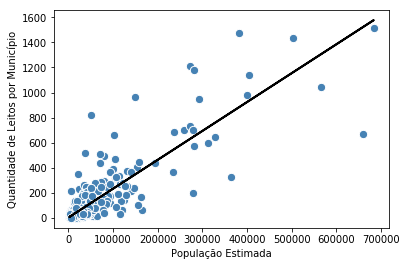

In [45]:
lin_regplot(X_test, y_test, regressor)
plt.xlabel('População Estimada')
plt.ylabel('Quantidade de Leitos por Município')
plt.show()

##### Com o resultado obtido na regressão linear simples é possível inferir que, talvez, os leitos das Unidades Básicas de Saúde não estejam distribuídos da melhor maneira ao longo do território brasileiro, como observado na análise acima, alguns casos com uma diferença muito grande entre o valor testado e o valor predito. Como é sabido, um dos maiores problemas do país reside no aspecto da saúde, e através do presente estudo podemos verificar a  maneira como esses leitos são distribuídos em todo território nacional.